In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_74187/756415508.py:4: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


2024-01-05 01:22:19 Configured OSMnx 1.1.2
2024-01-05 01:22:19 HTTP response caching is on


## Guadalajara hexagons

In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'

query = f"SELECT * FROM {schema}.{folder} WHERE \"CVEGEO\" = \'14039\'"

hex_gdf = proylib.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(1214, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c94313ffff,"POLYGON ((-103.30748 20.70684, -103.30626 20.7...",14039,Guadalajara,Guadalajara,urban


## Uso de suelo

In [3]:
us_gdf = gpd.read_file('../data/processed/GDL_D07_Usos_de_Suelo_2011.shp')
print(us_gdf.shape)
us_gdf.head(2)

(289582, 4)


,LAYER,DISTRITO,SD,geometry
0,Sin actividad registrada,7,1,"POLYGON ((669128.755 2285711.511, 669087.663 2..."
1,Sin actividad registrada,7,1,"POLYGON ((670889.528 2285305.617, 670866.552 2..."


<AxesSubplot: >

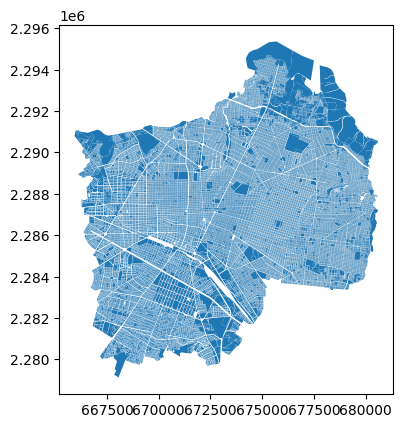

In [4]:
us_gdf.plot()

## Edificaciones

In [5]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [6]:
query = f"SELECT * FROM google_buildings.buildings_google_v3 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
ed_gdf = proylib.gdf_from_query(query, geometry_col='geometry')
print(ed_gdf.shape)
ed_gdf.head(4)

(698774, 7)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,cell
0,20.713705,-103.354066,46.7118,0.6940,"POLYGON ((-103.35402 20.71369, -103.35402 20.7...",75GRPJ7W+F9M9,843
1,20.710490,-103.350625,15.4477,0.6514,"POLYGON ((-103.35061 20.71046, -103.35061 20.7...",75GRPJ6X+5QRJ,843
2,20.714142,-103.352724,6.6972,0.6553,"POLYGON ((-103.35270 20.71414, -103.35270 20.7...",75GRPJ7W+MW2Q,843
3,20.711466,-103.350305,65.1793,0.7319,"POLYGON ((-103.35028 20.71142, -103.35027 20.7...",75GRPJ6X+HVPJ,843


## Manzanas

In [7]:
schema = 'marco'
table = 'mza_2020'

query = f'SELECT * FROM {schema}.{table} WHERE \"CVEGEO\" LIKE \'14039%%\''
mnz_gdf = proylib.gdf_from_query(query, geometry_col='geometry')
print(mnz_gdf.shape)
mnz_gdf.head(4)

(13790, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,1403900010878005,14,039,0001,0878,005,Urbana,Típica,"POLYGON ((-103.29176 20.69143, -103.29169 20.6..."
1,1403900013020059,14,039,0001,3020,059,Urbana,Típica,"POLYGON ((-103.30625 20.71851, -103.30638 20.7..."
2,1403900013020058,14,039,0001,3020,058,Urbana,Típica,"POLYGON ((-103.30662 20.71869, -103.30672 20.7..."
3,140390001418A052,14,039,0001,418A,052,Urbana,Típica,"POLYGON ((-103.28446 20.69343, -103.28485 20.6..."


## Intersecciones

In [8]:
nodes = gpd.read_file('../data/processed/nodes_gdl.shp')
print(nodes.shape)
nodes.head(2)

(24132, 18)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,vertex_pos,vertex_ind,vertex_par,vertex_p_1,distance,angle,geometry
0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,0,0,0,0,0.000000,78.590719,POINT (2356137.273 967663.731)
1,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,-1,3,0,3,564.209655,82.797005,POINT (2356686.712 967789.121)


## Vialidades

In [9]:
edges = gpd.read_file('../data/processed/vialidades_gdl.geojson')
edges = edges.explode()
print(edges.shape)
edges.head(4)

(36649, 12)


/tmp/ipykernel_74187/4088026504.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  edges = edges.explode()


,,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry
0,0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,"LINESTRING (-103.38695 20.71007, -103.38428 20..."
1,0,140390001,14,039,0001,03975,00008,Patria,Avenida,Dos sentidos,2,Urbana,"LINESTRING (-103.38166 20.71126, -103.38060 20..."
2,0,140390001,14,039,0001,03149,00001,Francisco Seles,Privada,Dos sentidos,2,Urbana,"LINESTRING (-103.39536 20.65548, -103.39518 20..."
3,0,140390001,14,039,0001,09070,00001,Malecón,Avenida,Dos sentidos,2,Urbana,"LINESTRING (-103.26992 20.69388, -103.26990 20..."


## Space syntax

In [10]:
ss_gdf = gpd.read_file('../data/processed/VialidadesAMG_AngularChoice_INEGI19_UTM_v3.shp')
print(ss_gdf.shape)
ss_gdf.head(2)

(208160, 8)


,id,NI_sl500,NI_sl500_N,NI_sl500_T,NI_sl500_M,AC_sl3k_wl,AC_sl3k_MD,geometry
0,1,0.865135,71,367.0,5.242857,1.522956,5.693864,"LINESTRING (667977.249 2290909.056, 668569.364..."
1,2,0.723562,74,449.0,6.150685,1.515390,5.802370,"LINESTRING (668569.364 2291047.785, 668625.351..."


## Spatial anaylsis

### Land use

In [11]:
us_gdf = us_gdf.to_crs("EPSG:4326")

In [12]:
us_hex = us_gdf.overlay(hex_gdf, how='intersection')
us_hex['area_ha_us'] = us_hex.to_crs("EPSG:32613").area/10000
print(us_hex.shape)
us_hex.head(2)

(319062, 10)


,LAYER,DISTRITO,SD,hex_id_9,CVEGEO,NOMGEO,city,type,geometry,area_ha_us
0,Sin actividad registrada,7,1,89498c96c73ffff,14039,Guadalajara,Guadalajara,urban,"POLYGON ((-103.37682 20.66296, -103.37686 20.6...",0.039996
1,Comercio y Servicios,7,1,89498c96c73ffff,14039,Guadalajara,Guadalajara,urban,"POLYGON ((-103.37735 20.66115, -103.37775 20.6...",0.110757


In [13]:
us_area = us_hex.groupby(['hex_id_9']).sum()
us_area = us_area.reset_index()[['hex_id_9','area_ha_us']]
us_area = us_area.rename(columns={'area_ha_us':'area_ha'})
us_area.head(2)

/tmp/ipykernel_74187/2901893028.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  us_area = us_hex.groupby(['hex_id_9']).sum()


,hex_id_9,area_ha
0,89498c94003ffff,8.119861
1,89498c94007ffff,8.173849


In [14]:
us_hex = us_hex.groupby(['hex_id_9','LAYER']).sum()
us_hex = us_hex.reset_index()
us_hex = us_hex.merge(us_area[['hex_id_9','area_ha']], on='hex_id_9')
print(us_hex.shape)
us_hex.head(2)

(5819, 6)


/tmp/ipykernel_74187/1672011573.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  us_hex = us_hex.groupby(['hex_id_9','LAYER']).sum()


,hex_id_9,LAYER,DISTRITO,SD,area_ha_us,area_ha
0,89498c94003ffff,Comercio y Servicios,285,57,0.945623,8.119861
1,89498c94003ffff,Espacios Abiertos,5,1,0.027123,8.119861


In [15]:
us_hex['pct'] = us_hex['area_ha_us'] / us_hex['area_ha']
us_hex = us_hex[['hex_id_9','LAYER','pct']]
us_hex.head(2)

,hex_id_9,LAYER,pct
0,89498c94003ffff,Comercio y Servicios,0.116458
1,89498c94003ffff,Espacios Abiertos,0.003340


In [16]:
us_hex = pd.pivot_table(us_hex,'pct',index='hex_id_9', columns='LAYER').reset_index()
us_hex.index.names = ['']
print(us_hex.shape)
us_hex.head(2)

(1211, 10)


LAYER,hex_id_9,Agropecuario,Baldios,Comercio y Servicios,Equipamiento,Espacios Abiertos,Habitacional,Industrial,Infraestructura,Sin actividad registrada
,,,,,,,,,,
0,89498c94003ffff,NaN,NaN,0.116458,NaN,0.003340,0.878489,NaN,NaN,0.001713
1,89498c94007ffff,NaN,NaN,0.163763,0.009889,0.005392,0.799105,0.019287,NaN,0.002563


In [17]:
us_hex = us_hex.fillna(0)

### Open space

In [18]:
mnz_diff = mnz_gdf.overlay(ed_gdf, how='difference')
print(mnz_diff.shape)
mnz_diff.head(2)

(13789, 9)


/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 952 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,1403900010878005,14,039,0001,0878,005,Urbana,Típica,"MULTIPOLYGON (((-103.29246 20.69015, -103.2925..."
1,1403900013020059,14,039,0001,3020,059,Urbana,Típica,"POLYGON ((-103.30625 20.71851, -103.30638 20.7..."


<AxesSubplot: >

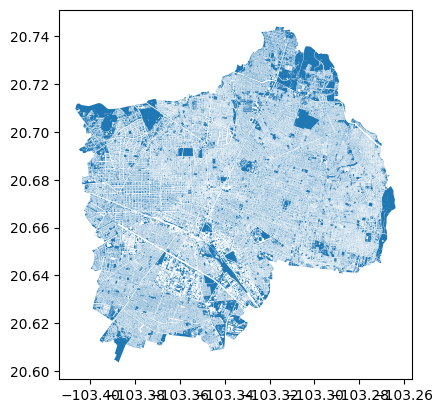

In [19]:
mnz_diff.plot()

1. Calcular área 2. Extraer centroides 3. Intersección por localización

In [20]:
mnz_diff_hex = mnz_diff.overlay(hex_gdf, how='intersection')
mnz_diff_hex = mnz_diff_hex.explode()

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 309 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
/tmp/ipykernel_74187/3521610243.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  mnz_diff_hex = mnz_diff_hex.explode()


In [21]:
mnz_diff_hex['area_dif_ha'] = mnz_diff_hex.to_crs("EPSG:32613").area/10000
print(mnz_diff_hex.shape)
mnz_diff_hex.head(2)

(134541, 15)


CVEGEO_1 CVE_ENT CVE_MUN CVE_LOC CVE_AGEB CVE_MZA  AMBITO  \
0 0  1403900010878005      14     039    0001     0878     005  Urbana   
  1  1403900010878005      14     039    0001     0878     005  Urbana   

    TIPOMZA         hex_id_9 CVEGEO_2       NOMGEO         city   type  \
0 0  Típica  89498c94283ffff    14039  Guadalajara  Guadalajara  urban   
  1  Típica  89498c94283ffff    14039  Guadalajara  Guadalajara  urban   

                                              geometry  area_dif_ha  
0 0  POLYGON ((-103.29251 20.69002, -103.29264 20.6...     0.345071  
  1  POLYGON ((-103.29210 20.69107, -103.29214 20.6...     0.003751

In [22]:
mnz_hex = mnz_gdf.overlay(hex_gdf, how='intersection')
mnz_hex = mnz_hex.explode()

/tmp/ipykernel_74187/1662265172.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  mnz_hex = mnz_hex.explode()


In [23]:
mnz_hex['area_tot_ha'] = mnz_hex.to_crs("EPSG:32613").area/10000
print(mnz_hex.shape)
mnz_hex.head(2)

(22703, 15)


,,CVEGEO_1,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,hex_id_9,CVEGEO_2,NOMGEO,city,type,geometry,area_tot_ha
0,0,1403900010878005,14,039,0001,0878,005,Urbana,Típica,89498c94283ffff,14039,Guadalajara,Guadalajara,urban,"POLYGON ((-103.29169 20.69140, -103.29186 20.6...",0.813581
1,0,1403900010897051,14,039,0001,0897,051,Urbana,Típica,89498c94283ffff,14039,Guadalajara,Guadalajara,urban,"POLYGON ((-103.28970 20.68912, -103.28957 20.6...",0.263198


In [24]:
mnz_hex = mnz_hex.groupby('hex_id_9').sum()
mnz_diff_hex = mnz_diff_hex.groupby('hex_id_9').sum()
mnz_hex = mnz_hex.reset_index()
mnz_diff_hex = mnz_diff_hex.reset_index()
mnz_hex = mnz_hex.merge(mnz_diff_hex, on='hex_id_9')

/tmp/ipykernel_74187/1931677954.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mnz_hex = mnz_hex.groupby('hex_id_9').sum()
/tmp/ipykernel_74187/1931677954.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mnz_diff_hex = mnz_diff_hex.groupby('hex_id_9').sum()


In [25]:
mnz_hex['pct'] = mnz_hex['area_dif_ha'] / mnz_hex['area_tot_ha']
mnz_hex.head(4)

,hex_id_9,area_tot_ha,area_dif_ha,pct
0,89498c94003ffff,9.688371,3.676144,0.379439
1,89498c94007ffff,9.313633,3.341602,0.358786
2,89498c9400bffff,9.664548,3.991290,0.412983
3,89498c9400fffff,8.638719,3.605189,0.417329


In [26]:
mnz_hex = mnz_hex[['hex_id_9','pct']]

### Number of intersections

In [27]:
nodes = nodes.to_crs("EPSG:4326")

In [28]:
nodes_hex = nodes.overlay(hex_gdf, how='intersection')
print(nodes_hex.shape)
nodes_hex.head(4)

(23684, 23)


,CVEGEO_1,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,...,vertex_par,vertex_p_1,distance,angle,hex_id_9,CVEGEO_2,NOMGEO,city,type,geometry
0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,...,0,0,0.000000,78.590719,8949ab4b6dbffff,14039,Guadalajara,Guadalajara,urban,POINT (-103.38695 20.71007)
1,140390001,14,039,0001,03975,00003,Patria,Avenida,Dos sentidos,2,...,0,0,0.000000,267.398205,8949ab4b6dbffff,14039,Guadalajara,Guadalajara,urban,POINT (-103.38834 20.70989)
2,140390001,14,039,0001,05345,00004,Antofagasta,Calle,Dos sentidos,2,...,0,2,89.338729,145.671296,8949ab4b6dbffff,14039,Guadalajara,Guadalajara,urban,POINT (-103.38654 20.70937)
3,140390001,14,039,0001,05339,00001,Antioquia,Calle,Dos sentidos,2,...,0,1,86.534703,358.815130,8949ab4b6dbffff,14039,Guadalajara,Guadalajara,urban,POINT (-103.38781 20.70902)


In [29]:
nodes_hex = nodes_hex.groupby('hex_id_9').count().reset_index()
nodes_hex = nodes_hex[['hex_id_9','CVEGEO_1']].rename(columns={'CVEGEO_1':'number_intersections'})
nodes_hex.head(4)

,hex_id_9,number_intersections
0,89498c94003ffff,12
1,89498c94007ffff,14
2,89498c9400bffff,17
3,89498c9400fffff,18


### Street area

In [30]:
edges = edges.to_crs("EPSG:4326")
edges_hex = edges.overlay(hex_gdf, how='intersection')
edges_hex['len_km'] = edges_hex.to_crs("EPSG:32613").length / 1000
edges_hex = edges_hex.groupby('hex_id_9').sum()
edges_hex = edges_hex.reset_index()
edges_hex = edges_hex[['hex_id_9','len_km']]
print(edges_hex.shape)
edges_hex.head(2)

(1164, 2)


/tmp/ipykernel_74187/4144223328.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  edges_hex = edges_hex.groupby('hex_id_9').sum()


,hex_id_9,len_km
0,89498c94003ffff,2.507559
1,89498c94007ffff,2.399977


In [31]:
tmp_hex = hex_gdf.overlay(mnz_gdf, how='difference')
tmp_hex['area_ha'] = tmp_hex.to_crs("EPSG:32613").area / 10000
tmp_hex = tmp_hex[['hex_id_9','area_ha']]
print(tmp_hex.shape)
tmp_hex.head(2)

(1211, 2)


,hex_id_9,area_ha
0,89498c96e0bffff,3.469683
1,89498c94313ffff,2.154660


In [32]:
edges_hex = edges_hex.merge(tmp_hex, on='hex_id_9')
edges_hex['street_dens'] = edges_hex['len_km'] / edges_hex['area_ha']
edges_hex = edges_hex[['hex_id_9','street_dens']]
edges_hex.head(4)

,hex_id_9,street_dens
0,89498c94003ffff,0.900961
1,89498c94007ffff,0.759933
2,89498c9400bffff,0.938217
3,89498c9400fffff,0.690427


### Space syntax

In [33]:
ss_gdf = ss_gdf.to_crs("EPSG:4326")
ss_gdf = ss_gdf[['NI_sl500','geometry']]
ss_hex = ss_gdf.overlay(hex_gdf, how='intersection')
print(ss_hex.shape)
ss_hex.head(2)

(54105, 7)


,NI_sl500,hex_id_9,CVEGEO,NOMGEO,city,type,geometry
0,0.865135,8949ab4b6dbffff,14039,Guadalajara,Guadalajara,urban,"LINESTRING (-103.38698 20.71018, -103.38579 20..."
1,0.807797,8949ab4b6dbffff,14039,Guadalajara,Guadalajara,urban,"LINESTRING (-103.38834 20.70997, -103.38879 20..."


In [34]:
ss_hex['length_km'] = ss_hex.to_crs("EPSG:32613").length / 1000
ss_tot = ss_hex.groupby('hex_id_9').sum()
ss_tot = ss_tot.reset_index()
ss_tot = ss_tot[['hex_id_9','length_km']]
ss_tot = ss_tot.rename(columns={'length_km':'length_tot_km'})
ss_tot.head(4)

/tmp/ipykernel_74187/3212174632.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ss_tot = ss_hex.groupby('hex_id_9').sum()


,hex_id_9,length_tot_km
0,89498c94003ffff,2.507217
1,89498c94007ffff,2.400254
2,89498c9400bffff,2.633676
3,89498c9400fffff,2.646655


In [35]:
ss_hex = ss_hex.merge(ss_tot, on='hex_id_9')
ss_hex['pct_ss'] = ss_hex['length_km'] / ss_hex['length_tot_km']
ss_hex['wgt_ss'] = ss_hex['pct_ss'] * ss_hex['NI_sl500']
ss_hex = ss_hex.groupby('hex_id_9').sum()
ss_hex = ss_hex.reset_index()
ss_hex = ss_hex[['hex_id_9','wgt_ss']]
ss_hex.head(2)

/tmp/ipykernel_74187/660076386.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ss_hex = ss_hex.groupby('hex_id_9').sum()


,hex_id_9,wgt_ss
0,89498c94003ffff,1.147223
1,89498c94007ffff,1.049694


## Hexagon data

In [36]:
hex_gdf = hex_gdf.merge(us_hex, on='hex_id_9')
hex_gdf = hex_gdf.merge(mnz_hex, on='hex_id_9')
hex_gdf = hex_gdf.merge(edges_hex, on='hex_id_9')
hex_gdf = hex_gdf.merge(ss_hex, on='hex_id_9')
print(hex_gdf.shape)
hex_gdf.head(4)

(1160, 18)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,Agropecuario,Baldios,Comercio y Servicios,Equipamiento,Espacios Abiertos,Habitacional,Industrial,Infraestructura,Sin actividad registrada,pct,street_dens,wgt_ss
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,0.0,0.004079,0.355602,0.022251,0.000000,0.455789,0.022372,0.000000,0.139907,0.401130,0.791346,1.129919
1,89498c94313ffff,"POLYGON ((-103.30748 20.70684, -103.30626 20.7...",14039,Guadalajara,Guadalajara,urban,0.0,0.000000,0.071396,0.194513,0.000000,0.712030,0.002846,0.007446,0.011768,0.492215,0.902104,1.087387
2,89498c96c6fffff,"POLYGON ((-103.37488 20.66777, -103.37366 20.6...",14039,Guadalajara,Guadalajara,urban,0.0,0.006941,0.158567,0.022175,0.000000,0.812317,0.000000,0.000000,0.000000,0.577184,0.683888,1.169672
3,8949ab5922bffff,"POLYGON ((-103.38389 20.64104, -103.38267 20.6...",14039,Guadalajara,Guadalajara,urban,0.0,0.000000,0.120198,0.063860,0.079605,0.702501,0.010629,0.000000,0.023207,0.503515,0.886612,0.826984


<AxesSubplot: >

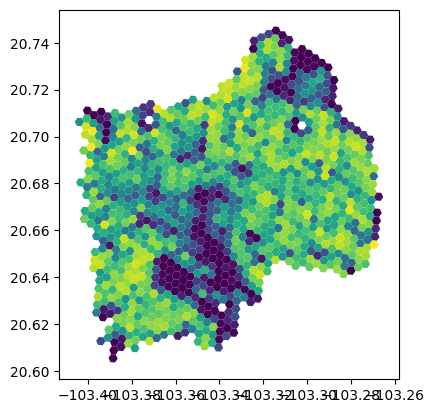

In [37]:
hex_gdf.plot('Habitacional')

<AxesSubplot: >

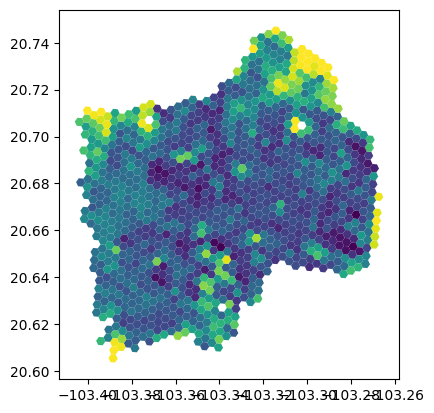

In [38]:
hex_gdf.plot('pct')

<AxesSubplot: >

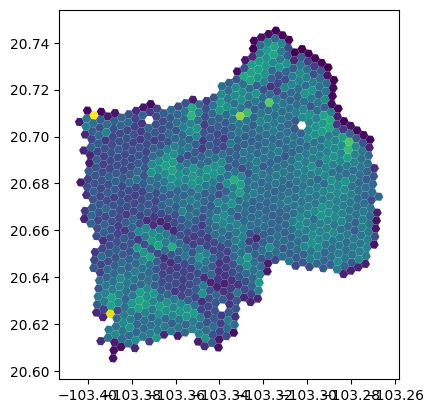

In [40]:
hex_gdf.plot('street_dens')

<AxesSubplot: >

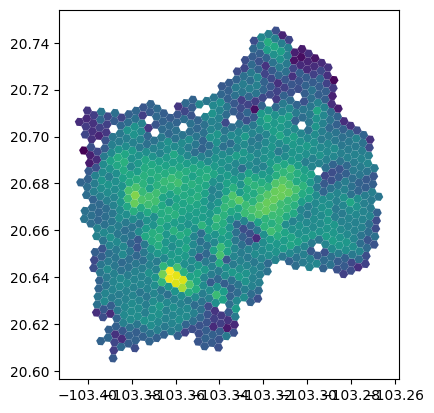

In [41]:
hex_gdf.plot('wgt_ss')

In [42]:
hex_gdf.to_file('../data/processed/hex_urban_structure.geojson')